In [143]:
#import a bunch of packages that might be useful

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import xgboost
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import matplotlib.patches as mpatches

In [144]:
#import the datasets (not really using the test one)

d_train = pd.read_csv(r'/Users/Birraunlitro/Desktop/S/Uni/Master/CentraleSupelec/ML/Assignment/ML-DSBA-Assignment_2_Kaggle/train.csv')
d_test = pd.read_csv(r'/Users/Birraunlitro/Desktop/S/Uni/Master/CentraleSupelec/ML/Assignment/ML-DSBA-Assignment_2_Kaggle/test.csv')

#drop the first column which is generated automatically while importing

d_train.drop('Unnamed: 0', axis=1, inplace=True)
d_test.drop('Unnamed: 0', axis=1, inplace=True)

#drop useless records and reset indexes 

d_train.dropna(axis=0, inplace=True)
d_train.set_index(np.arange(len(d_train)), inplace=True)

In [145]:
d_train

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76634,"Wed, 19 Jul 2017 00:24:33 +0000",amazon,in,0,0,multipart/mixed,0,0,0,0,15.0,4,1
76635,"Tue, 07 Apr 2015 14:12:29 +0000 (UTC)",quora,com,0,0,multipart/alternative,0,88,1,1,98.0,80913,1
76636,"Tue, 30 Jun 2020 05:55:20 -0700",github,com,1,0,multipart/alternative,0,8,0,0,91.0,1307,3
76637,"Tue, 26 May 2020 08:18:43 -0700",google,com,0,0,multipart/alternative,27,85,0,0,46.0,28485,0


In [146]:
#function that converts all the values present in the 'date' column into a datetime value

import datetime
import re 

def date(date_string, i):
    
    date_string = re.sub("[\(\[].*?[\)\]]", "", str(date_string)).rstrip()
    if date_string[-4:] == '0580':
        date_string = date_string[:-5].rstrip()
        
    try:
        x = datetime.datetime.strptime(date_string, '%a, %d %b %Y %H:%M:%S %z')
        return x
    except ValueError:
        
        try:
            x = datetime.datetime.strptime(date_string, '%d %b %Y %H:%M:%S %z')
            return x
        except ValueError:
            
            try:
                x = datetime.datetime.strptime(date_string, '%a, %d %b %Y %H:%M:%S')
                return x
            except ValueError:
                
                try:
                    x = datetime.datetime.strptime(date_string, '%a, %d %b %Y %H:%M:%S %Z')
                    return x
                except ValueError:
                    try:
                        x = datetime.datetime.strptime(date_string, '%d %b %Y %H:%M:%S')
                        return x
                    except ValueError:
                        return i

In [147]:
#create a list with datetime values 

datetime_type = []
for i in range(len(d_train)):
    datetime_type.append(date(d_train['date'][i], i))

In [148]:
#find which values couldn't be converted 

to_drop = []
for i in range(len(datetime_type)):
    if type(datetime_type[i]) != datetime.datetime:
        to_drop.append(i)
to_drop

[40409, 65003]

In [149]:
#drop the values that couldn't be converted

d_train.drop(to_drop, axis=0, inplace=True)
d_train.set_index(np.arange(len(d_train)), inplace=True)
k = 0
for i in range(len(to_drop)):
    datetime_type.pop(to_drop[i]-k)
    k += 1

In [150]:
#create a new column with the datetime values using the previous created list datetime

d_train['proper_date'] = np.zeros(len(d_train))
for i in range(len(d_train)):
    d_train['proper_date'][i] = datetime_type[i]

/Users/Birraunlitro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [151]:
#create a bunch of varaibles that might be useful

d_train['year'] = np.zeros(len(d_train))
d_train['month'] = np.zeros(len(d_train))
d_train['day'] = np.zeros(len(d_train))
d_train['day_of_week'] = np.zeros(len(d_train))
d_train['hour'] = np.zeros(len(d_train))
d_train['minute'] = np.zeros(len(d_train))
d_train['second'] = np.zeros(len(d_train))
d_train['timezone'] = np.zeros(len(d_train))

In [152]:
#assign values to the new variables 

for i in range(len(d_train)):
    d_train['year'][i] =  d_train['proper_date'][i].year
    d_train['month'][i] =  d_train['proper_date'][i].month
    d_train['day'][i] =  d_train['proper_date'][i].day
    d_train['hour'][i] =  d_train['proper_date'][i].hour
    d_train['minute'][i] =  d_train['proper_date'][i].minute
    d_train['second'][i] =  d_train['proper_date'][i].second
    d_train['timezone'][i] =  d_train['proper_date'][i].tzinfo
    d_train['day_of_week'][i] = d_train['proper_date'][i].weekday()

/Users/Birraunlitro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Birraunlitro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Birraunlitro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Bi

In [153]:
d_train.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,...,label,proper_date,year,month,day,day_of_week,hour,minute,second,timezone
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,...,2,2017-11-06 11:13:45+01:00,2017.0,11.0,6.0,0.0,11.0,13.0,45.0,UTC+01:00
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,...,1,2018-02-14 11:00:16+00:00,2018.0,2.0,14.0,2.0,11.0,0.0,16.0,UTC
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,...,1,2016-07-06 19:53:37+00:00,2016.0,7.0,6.0,2.0,19.0,53.0,37.0,UTC
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,...,1,2019-10-11 11:25:40+02:00,2019.0,10.0,11.0,4.0,11.0,25.0,40.0,UTC+02:00
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,...,1,2017-11-07 11:07:18+00:00,2017.0,11.0,7.0,1.0,11.0,7.0,18.0,UTC


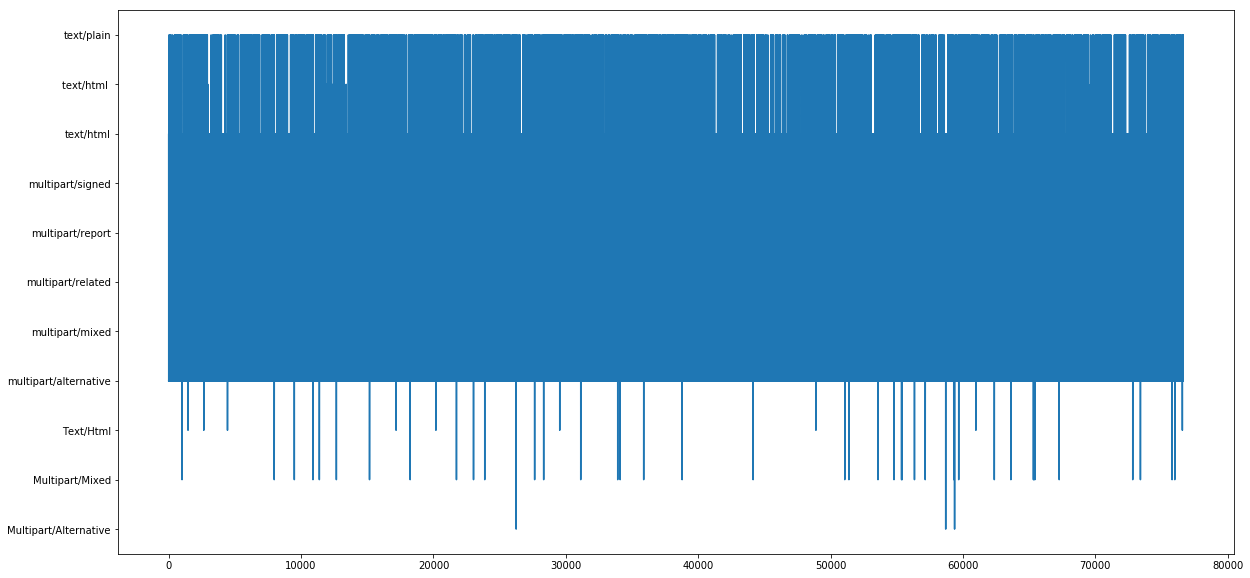

In [154]:
#check for outliers in 'mail_type'
#p.s. even if theere are few records of some types they are important because they lead to one label

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(d_train)), d_train['mail_type'])
plt.show()

In [155]:
#just getting some info

d_train['mail_type'].value_counts()

multipart/alternative    57047
text/html                 9605
multipart/mixed           6036
multipart/related         1977
text/plain                1826
text/html                   58
Multipart/Mixed             39
multipart/signed            26
Text/Html                   10
multipart/report            10
Multipart/Alternative        3
Name: mail_type, dtype: int64

In [156]:
#same here

d_train['label'].value_counts()

1    35446
0    16482
3    10560
2     8550
7     5042
4      309
6      151
5       97
Name: label, dtype: int64

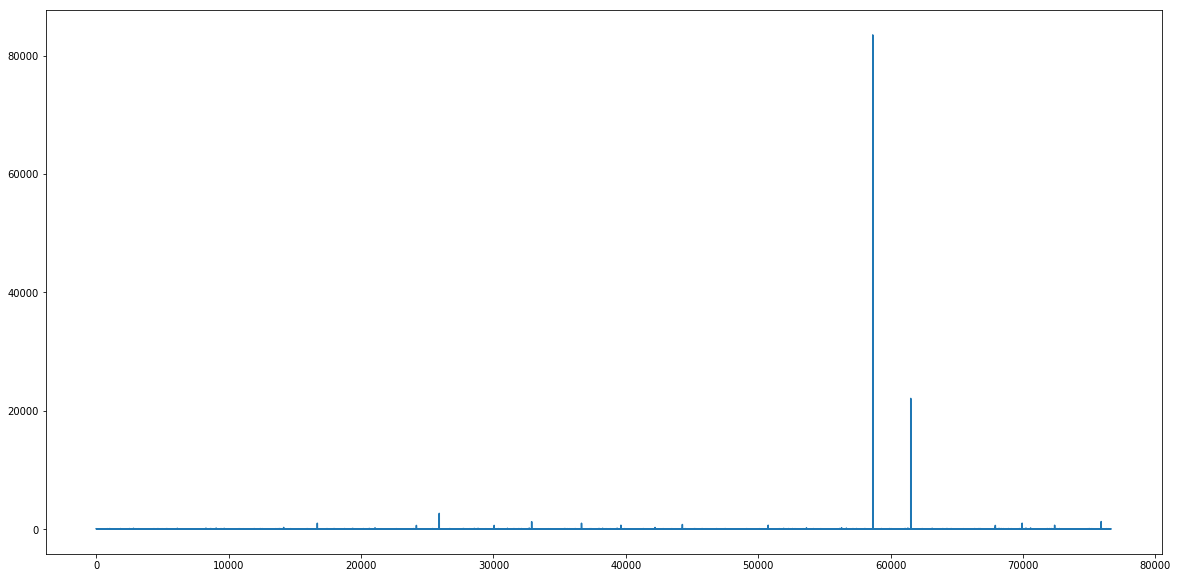

In [157]:
#check for outliers in 'images'

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(d_train)), d_train['images'])
plt.show()

In [158]:
#drop all the records whose 'images' value is larger than 1000 (outliers)

td = []
for i in range(len(d_train)):
    if d_train['images'][i] > 1000:
        td.append(i)
        
d_train.drop(td, axis=0, inplace=True)
d_train.set_index(np.arange(len(d_train)), inplace=True)

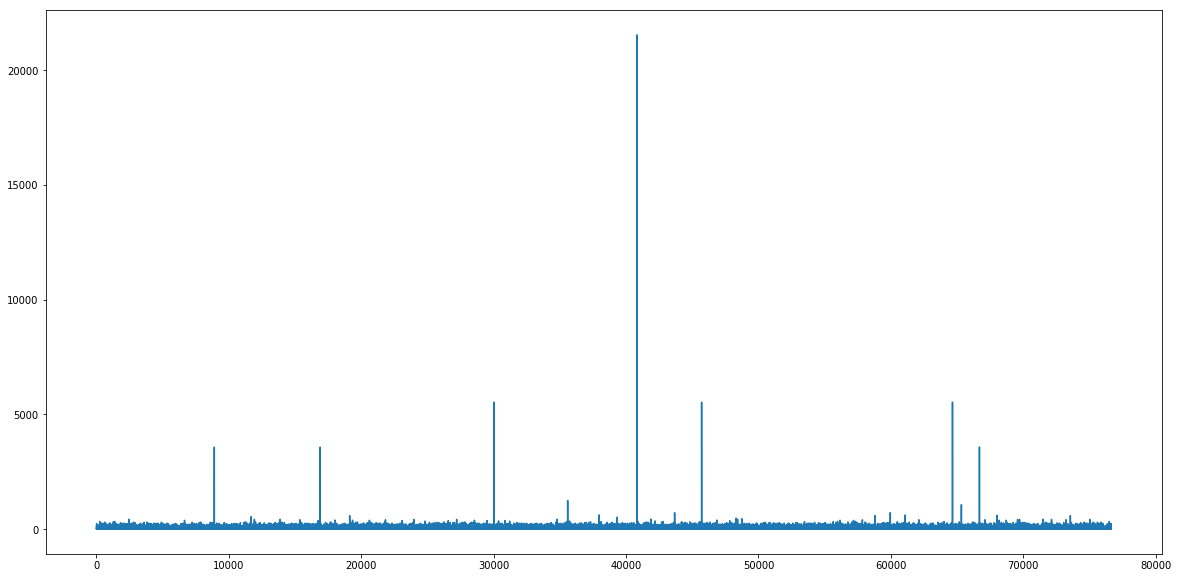

In [159]:
#check for outliers in 'urls'

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(d_train)), d_train['urls'])
plt.show()

In [160]:
#drop all the records whose 'urls' value is larger than 1000 (outliers)

td = []
for i in range(len(d_train)):
    if d_train['urls'][i] > 1000:
        td.append(i)
        
d_train.drop(td, axis=0, inplace=True)
d_train.set_index(np.arange(len(d_train)), inplace=True)

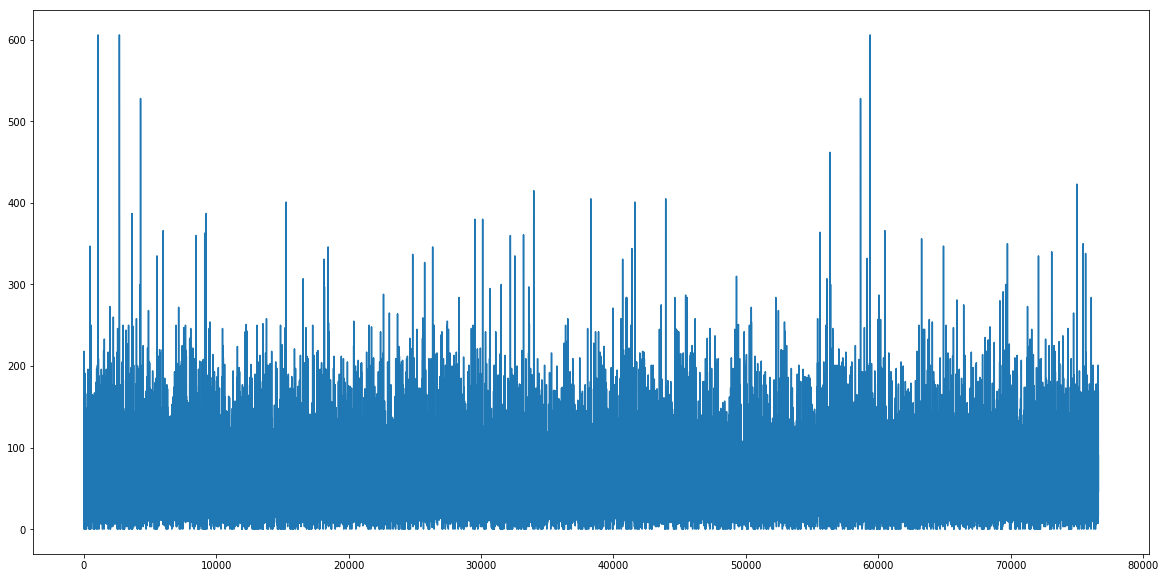

In [161]:
#check for outliers in 'chars_in_subject' 
#they look ok to me

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(d_train)), d_train['chars_in_subject'])
plt.show()

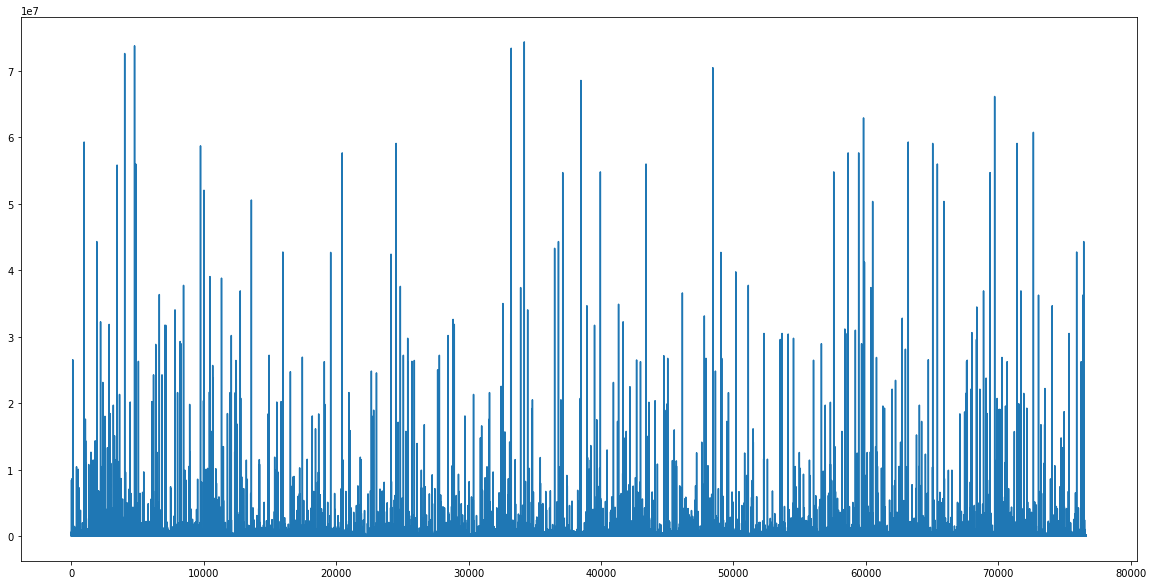

In [162]:
#check for outliers in 'chars_in_body' 
#they look ok to me

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(d_train)), d_train['chars_in_body'])
plt.show()

In [179]:
#create a funtion to reduce the number of values of 'org' and 'tld' mainly

#takes as input the dataset (d_train), an argument ('org', 'tld' or any other column) and the number of value_counts 
#under which we will lose info
def rename(dataset, argument, n):
    count_ = d_train[argument].value_counts()
    
    #creating a list with the values present in the column of interest
    list_ = [str(count_[i:i+1].keys).split('of ')[1].split(' ')[0] for i in range(len(count_))]
    
    #replacing the values in the list which value in 'count' in less that n
    for i in range(len(count_)):
        if count_[i] < n:
            list_[i] = 'other'
            
    #retun the list with the values present in the column of interest (some of them subsituded by 'other')
    return list_
    
#calling the function for 'org' and 'tld'

list_important_org = rename(d_train, 'org', 250)
list_important_tld = rename(d_train, 'tld', 150)
    
#create a function that substitue the value of a colummn with 'other' according to the instruction given by the 
#function rename

#takes as input the value of a given column at a given position and the list created by the funtion rename
def change(value, list_imp):
    if value not in list_imp:
        return 'other'
    else:
        return value

In [180]:
#substituting values of 'org' and 'tld' variables using change funtion

for i in range(len(d_train)):
    d_train['org'][i] = change(d_train['org'][i], list_important_org)
    d_train['tld'][i] = change(d_train['tld'][i], list_important_tld)

/Users/Birraunlitro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Birraunlitro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [163]:
d_train.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,...,label,proper_date,year,month,day,day_of_week,hour,minute,second,timezone
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,...,2,2017-11-06 11:13:45+01:00,2017.0,11.0,6.0,0.0,11.0,13.0,45.0,UTC+01:00
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,...,1,2018-02-14 11:00:16+00:00,2018.0,2.0,14.0,2.0,11.0,0.0,16.0,UTC
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,...,1,2016-07-06 19:53:37+00:00,2016.0,7.0,6.0,2.0,19.0,53.0,37.0,UTC
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,...,1,2019-10-11 11:25:40+02:00,2019.0,10.0,11.0,4.0,11.0,25.0,40.0,UTC+02:00
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,...,1,2017-11-07 11:07:18+00:00,2017.0,11.0,7.0,1.0,11.0,7.0,18.0,UTC


In [164]:
#drop some variables
#'mineute' and 'second' are not so important in my opinion, we already have hour (change my mind please)
#'day' is not that import, I guess 'day_of_week' is more interesting to consider (change my mind please)
#'proper_date' and 'date' are redundant (I'll change your mind if u disagree)
#'year' same as before, doesn't look that important (change my mind please)

d_train.drop(['minute', 'second', 'day', 'proper_date', 'year', 'date'], axis=1, inplace=True)

In [108]:
#WE DON'T NEED THIS CELL IF WE ARE USING CATBOOS MODEL SINCE IT HAS A BUILT IN ENCODED FUNCTION 

#function use to encode a bunch of variables

#takes as input the dataset
def encode_varibles(dataframe):
    
    #encodes the variables 'org', 'tld', 'mail_type', 'month', 'day_of_week', 'hour', 'timezone'
    new_dataframe = pd.get_dummies(dataframe, prefix=['Org', 'Tld', 'Type', 'Month', 'Weekday', 'Hour', 'Timezone'], columns=['org', 'tld', 'mail_type', 'month', 'day_of_week', 'hour', 'timezone'])  
    
    #returns the dataset encoded
    return new_dataframe

k = encode_varibles(d_train)

Index(['ccs', 'bcced', 'images', 'urls', 'salutations', 'designation',
       'chars_in_subject', 'chars_in_body', 'label', 'Org_accounts',
       ...
       'Timezone_UTC+11:00', 'Timezone_UTC+10:00', 'Timezone_UTC+04:30',
       'Timezone_UTC+09:00', 'Timezone_UTC+04:00', 'Timezone_UTC+05:45',
       'Timezone_UTC+07:00', 'Timezone_UTC+05:00', 'Timezone_UTC-03:00',
       'Timezone_UTC+03:30'],
      dtype='object', length=156)

In [165]:
d_train.head()

,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,month,day_of_week,hour,timezone
0,reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2,11.0,0.0,11.0,UTC+01:00
1,edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1,2.0,2.0,11.0,UTC
2,usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1,7.0,2.0,19.0,UTC
3,granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1,10.0,4.0,11.0,UTC+02:00
4,github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1,11.0,1.0,11.0,UTC


In [181]:
#the encoded function of catboost can't handle the timezone

lb = d_train.drop('timezone', axis=1)

In [182]:
#splitting dataset for train and test

label = lb['label']
train = lb.drop('label', axis=1)
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.1, random_state=2)

In [183]:
#create and run the model

from catboost import CatBoostClassifier, Pool

#indicating which features are not categorical
categorical_features_indices = np.where(train.dtypes != np.float)[0]
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)

#actual model
cat = CatBoostClassifier(iterations=80, learning_rate=0.1, depth=10, one_hot_max_size=1500)
cat.fit(train_pool)

#make prediction for evaluation
y_pred_cat = cat.predict(x_test)

0:	learn: 1.8602992	total: 659ms	remaining: 52.1s
1:	learn: 1.7063142	total: 1.41s	remaining: 54.9s
2:	learn: 1.5921605	total: 2.08s	remaining: 53.4s
3:	learn: 1.5032657	total: 2.78s	remaining: 52.8s
4:	learn: 1.4271883	total: 3.28s	remaining: 49.2s
5:	learn: 1.3676307	total: 3.8s	remaining: 46.9s
6:	learn: 1.3181540	total: 4.33s	remaining: 45.1s
7:	learn: 1.2742515	total: 4.88s	remaining: 43.9s
8:	learn: 1.2340918	total: 5.39s	remaining: 42.5s
9:	learn: 1.2001326	total: 5.86s	remaining: 41s
10:	learn: 1.1653350	total: 6.36s	remaining: 39.9s
11:	learn: 1.1373427	total: 7.03s	remaining: 39.9s
12:	learn: 1.1135757	total: 7.63s	remaining: 39.3s
13:	learn: 1.0948341	total: 8.16s	remaining: 38.5s
14:	learn: 1.0764495	total: 8.68s	remaining: 37.6s
15:	learn: 1.0577710	total: 9.15s	remaining: 36.6s
16:	learn: 1.0425070	total: 9.7s	remaining: 36s
17:	learn: 1.0283750	total: 10.2s	remaining: 35.2s
18:	learn: 1.0170344	total: 10.7s	remaining: 34.4s
19:	learn: 1.0058589	total: 11.2s	remaining: 33

In [184]:
#get accuracy

from sklearn.metrics import accuracy_score

print('Accuracy ' + str(accuracy_score(y_test, y_pred_cat)))

Accuracy 0.6549654182435077
